In [1]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import lax, random, vmap
from jax.scipy.special import logsumexp
import flax
from flax.linen import *

import numpyro
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoDelta, AutoLowRankMultivariateNormal
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.util import find_stack_level, not_jax_tracer
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# データの確認

今回は社員の出張回数に関するデータを扱って、ポアソン分布による当てはめとゼロ過剰ポアソン分布による当てはめのどちらが尤もらしいのかを確認します。

In [2]:
y = np.array([
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0])

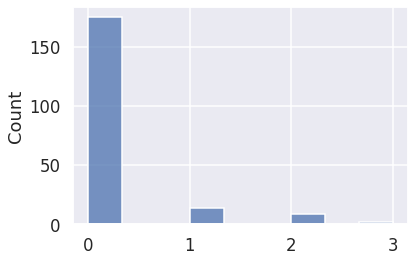

In [4]:
sns.histplot(y);

## ポアソン分布での当てはめ

In [5]:
def model(y=None, N=0):
    lam = numpyro.sample("lam", dist.HalfNormal(10))

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.Poisson(lam), obs=y)

nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=5000, num_chains=4)

rng_key = random.PRNGKey(1)
mcmc.run(rng_key=rng_key, y=y, N=len(y))
samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:01<00:00, 5919.79it/s, 3 steps of size 9.49e-01. acc. prob=0.94]


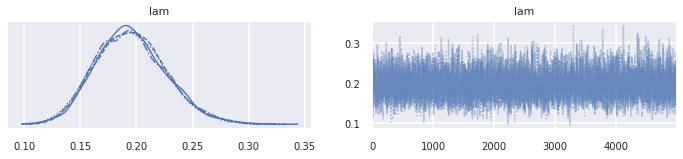

In [6]:
az.plot_trace(idata);

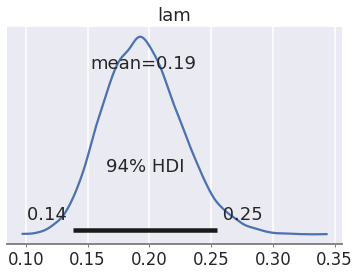

In [7]:
az.plot_posterior(idata);

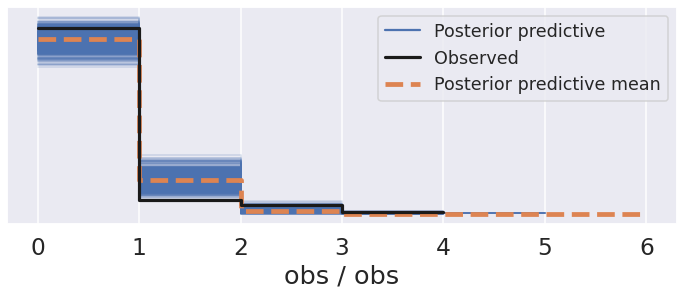

In [11]:
predictive = Predictive(model, samples)
ppc_samples = predictive(rng_key, N=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=1000, figsize=(12, 4));

葵の中に黒が埋まっていないのでちょっと事後予測が怪しいかもしれないように見える。

In [12]:
idata.to_netcdf("./result_data/idata.nc")

'./result_data/idata.nc'

## ゼロ過剰ポアソン分布での当てはめ

$$
f(x \mid \psi, \lambda)=\left\{\begin{array}{cc}
(1-\psi)+\psi \cdot e^{-\lambda}, & \text { if } x=0 \\
\psi \cdot \frac{\lambda^{x} e^{-\lambda}}{x !}, & \text { if } x=1,2,3, \cdots
\end{array}\right.
$$

In [13]:
def model(y=None, N=0):
    psi = numpyro.sample("psi", dist.Uniform(0,1))
    lam = numpyro.sample("lambuda", dist.HalfNormal(10))

    with numpyro.plate("data", N):
        numpyro.sample("obs", dist.ZeroInflatedPoisson(psi,lam), obs=y)

nuts = NUTS(model)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=5000, num_chains=4)

rng_key = random.PRNGKey(1)
mcmc.run(rng_key=rng_key, y=y, N=len(y))
samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:01<00:00, 5487.57it/s, 7 steps of size 5.47e-01. acc. prob=0.92]


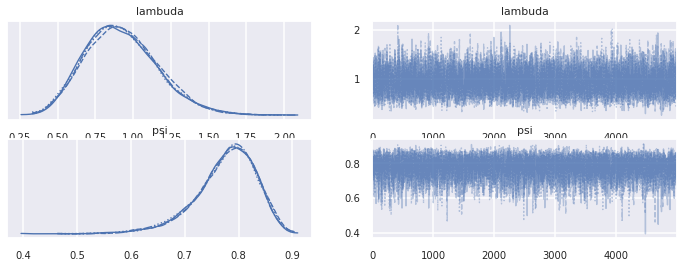

In [18]:
az.plot_trace(idata);

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambuda,0.923,0.240,0.488,1.369,0.003,0.002,6231.0,6748.0,1.0
psi,0.776,0.057,0.666,0.872,0.001,0.001,6465.0,6923.0,1.0


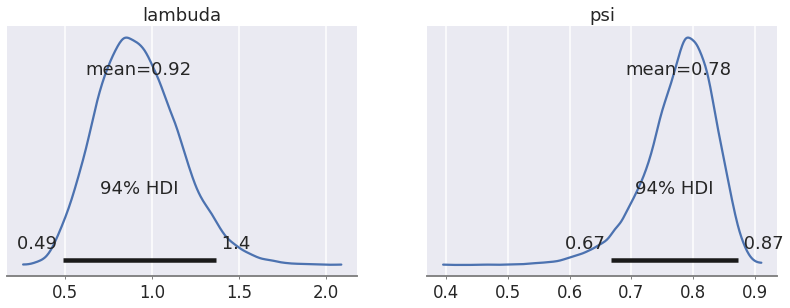

In [16]:
az.plot_posterior(idata);

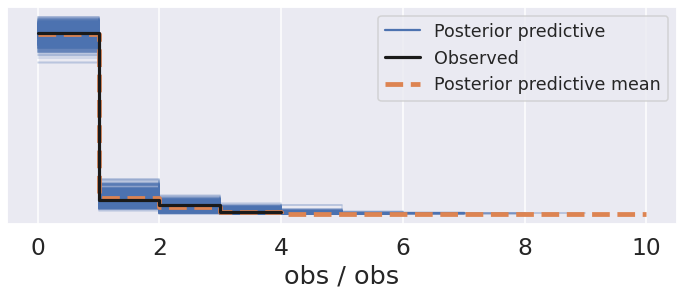

In [19]:
predictive = Predictive(model, samples)
ppc_samples = predictive(rng_key, N=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=1000, figsize=(12, 4));

## ２つの分布のあてはまりを比較する

### 汎化損失

仮定した何らかのモデルから得られている予測分布$p^*(x)$と真の分布$q(x)$の交差エントロピー

$$
\begin{align*}
G_n &= -\int q(x)\log p^*(x)\mathrm{d}x\\
    &=-\int q(x)\log q(x)\mathrm{d}x - \int q(x)\log\frac{q(x)}{p^*(x)}\mathrm{d}x\\
    &=H(q) + D(q\Vert p^*)
\end{align*}
$$

を汎化損失と呼びます。これは真の分布から得られているデータがどれくらい事後予測分布に当てはまるかを表していて、小さければそれだけ真の分布に近いことを表しています。

この指標自体は$q(x)$が未知である以上実際に計算することはできませんが、手元データに対する当てはまり度合いである経験損失$T_n$と、汎化損失に対する経験損失の偏り$b(X^n)$を考えることができます。経験損失は以下のようにかんたんな期待値計算で求めることができます。

$$
\begin{align*}
T_n=-\frac{1}{n}\sum^n_{i=1}\log p^*(x_i)\\
\end{align*}
$$

一方、偏りについては以下の汎関数分散$V_n$を$n$で除算したものに一致することが知られています。

$$
\begin{align*}
V_n=\sum_{i=0}^{n}\left\{E_{\theta}\left[\left(\log p\left(X_{i} \mid \theta\right)\right)^{2}\right]-E_{\theta}\left[\log p\left(X_{i} \mid \theta\right)\right]^{2}\right\}
\end{align*}
$$

ここで$E_{\theta}$はパラメータの事後分布に基づく期待値計算です。経験損失と偏りの和は漸近的に汎化損失と期待値が一致することが理論的に示されていて、この指標はWAICと呼ばれています。

$$
\begin{align*}
WAIC=T_n+\frac{V_n}{n}
\end{align*}
$$

WAICは「広く使える情報量基準」などと呼ばれるくらいで、AICのように真の分布が確率モデルの中に含まれている必要はなく、正則でないような性質のきれいではない対象に対しても利用することができます。

WAICは（特に海外では）$2n$倍した形で以下のような定義がされることもあります。

$$
\begin{align*}
WAIC=-2\sum_{i=1}^{N} \log \left(\frac{1}{S} \sum_{s=1}^{S} p\left(x_{i} \mid \theta^{s}\right)\right) +2\sum_{i=1}^{N} V_{s=1}^{S}\left(\log p\left(x_{i} \mid \theta^{s}\right)\right)

\end{align*}
$$

ここで$S$はサンプリング数で、MCMCサンプルによる近似計算を記しています。これらの計算はarvizの中でWAICの計算や複数のモデル間の比較などが簡単にできるようになっています。

In [20]:
az.waic(idata, scale="deviance")

Computed from 20000 by 200 log-likelihood matrix

              Estimate       SE
deviance_waic   201.06    27.93
p_waic            1.73        -

In [21]:
az.loo(idata, scale="deviance") #PSIS-LOO-CV

Computed from 20000 by 200 log-likelihood matrix

             Estimate       SE
deviance_loo   201.06    27.93
p_loo            1.73        -

In [22]:
idata_poisson = az.from_netcdf("./result_data/idata.nc")

In [24]:
dict_idata = {"Poisson":idata_poisson, "Zero Inflated Poisson":idata}
df_waic = az.compare(dict_idata, ic="waic", scale="deviance")
df_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Zero Inflated Poisson,0,201.055543,1.728291,0.000000,1.0,27.932949,0.00000,False,deviance
Poisson,1,224.511061,1.602943,23.455518,0.0,31.727968,9.95585,False,deviance


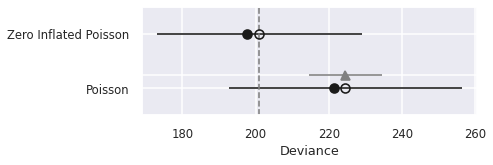

In [25]:
az.plot_compare(df_waic);